In [1]:
%pylab inline

import os, styles
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import L_sun

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mean_wl(passband):
    return trapz(passband[:,0] * passband[:,1], passband[:,0])/trapz(passband[:,1], passband[:,0])

In [3]:
sdss_reds = loadtxt("data/redshifts.dat", usecols=(1,))
sdss_seds = loadtxt("data/table_sdss.galaxies.dat")

used_filter_names = loadtxt("data/filters.sdss.dat", dtype=np.str, usecols=(1,))

filter_names = [file for root, subs, files in os.walk("filters") for file in files if file.endswith(".res")]
filter_names = [filter_names[j] for i in xrange(len(used_filter_names)) for j in xrange(len(filter_names)) if filter_names[j].startswith(used_filter_names[i])]

jpas_right_order = range(58)
jplus_right_order = range(58,len(filter_names))

jpas_filters = array(filter_names)[jpas_right_order]
jplus_filters = array(filter_names)[jplus_right_order]

In [4]:
#COMPUTE THE MEAN WAVELENGTH
jpas_wl = array([mean_wl(loadtxt("filters/{}".format(fname))) for fname in jpas_filters])
jplus_wl = array([mean_wl(loadtxt("filters/{}".format(fname),usecols=(0,2))) for fname in jplus_filters])
#SORT BY WAVELENGTH
jpas_isort = argsort(jpas_wl)
jplus_isort = argsort(jplus_wl)

jpas_filters = array(jpas_filters)[jpas_isort]
jpas_wl = jpas_wl[jpas_isort]

jplus_filters = array(jplus_filters)[jplus_isort]
jplus_wl = jplus_wl[jplus_isort]

jpas_fl = sdss_seds[0::2,jpas_right_order][:,jpas_isort]
jpas_sg = sdss_seds[1::2,jpas_right_order][:,jpas_isort]
jplus_fl = sdss_seds[0::2,jplus_right_order][:,jplus_isort]
jplus_sg = sdss_seds[1::2,jplus_right_order][:,jplus_isort]

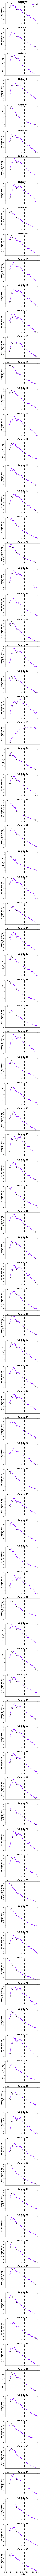

In [5]:
write_sed_files = True
NGAL = jpas_fl.shape[0]

jpas_mask = ones(jpas_fl.shape[1], dtype=bool)
jpas_mask[28:35] = False
jpas_mask = (jpas_fl>0.0)&(repeat([jpas_mask],NGAL,axis=0))
jpas_mask[[79,83],-7:] = False
jpas_mask[[89,91],-6:] = False
jpas_mask[[0,2,7,8,30,34,35,36,40,41,62,67],-5:] = False
jpas_mask[[3,5,6,9,10,11,12,18,29,31,38,43,44,47,48,49,53,54,55,56,60,61,63,64,71,80,81,87,88,94,97],-4:] = False
jpas_mask[[1,4,13,14,15,16,19,20,22,23,24,25,26,27,28,32,33,37,39,42,45,46,50,51,52,57,65,66,68,69,70,72,73,74,75,76,77,82,84,86,90,92,93,95,98,99],-3:] = False
jpas_mask[[17,21,58,59,78,85,96],-2:] = False

jplus_mask = ones(jplus_fl.shape[1], dtype=bool)
jplus_mask[5] = False
jplus_mask = (jplus_fl>0.0)&(repeat([jplus_mask],jplus_fl.shape[0],axis=0))
jplus_mask[[0,2,6,7,8,34,35,36,40,41,67,79,83,89,91],-1:] = False

distances = FlatLambdaCDM(H0=70, Om0=0.3).luminosity_distance(sdss_reds).cgs.value
d_correction = 4*pi*distances*(distances/L_sun.cgs.value)

fig, axs = subplots(NGAL, 1, sharex=True, figsize=(5, NGAL*3))
for i in xrange(NGAL):
    axs[i].set_title(r"\bf Galaxy {}".format(i))
    axs[i].plot(jpas_wl[jpas_mask[i]], jpas_fl[i][jpas_mask[i]], "-o", ms=4, mew=0, label=r"\bf J-PAS")
    axs[i].plot(jplus_wl[jplus_mask[i]], jplus_fl[i][jplus_mask[i]], "o", mfc="none", ms=7, mew=1, label=r"\bf J-PLUS")
    
    axs[i].axvline(6562.80, ls="--", color="k")
    axs[i].axvline(4101.76, ls="--", color="k")
    
    axs[i].set_ylabel(r"\bf Flux (erg/s/cm${}^{2}$/\AA)")

axs[0].legend(loc=0)
axs[i].set_xlabel(r"\bf $\lambda$ (\AA)")
axs[i].set_xlim(3000,9500)
fig.tight_layout()
#fig.savefig("SDSS_sample.png", bbox_inches="tight")

#WRITE SEDs
if write_sed_files:
    jpas_fl[~jpas_mask] = 0.0
    jpas_sg[~jpas_mask] = 0.0
    jplus_fl[~jplus_mask] = 0.0
    jplus_sg[~jplus_mask] = 0.0
    
    fmt = "%8.3f%12.4e%12.4e"
    hdr = "%6s%12s%12s"%tuple("weff flux error".split())
    for i in xrange(NGAL):
        jpas_table = column_stack((jpas_wl, jpas_fl[i]*d_correction[i], jpas_sg[i]*d_correction[i]))
        savetxt("obs-seds/jpas_{0:03d}.txt".format(i+1), jpas_table, fmt=fmt, header=hdr)

        jplus_table = column_stack((jplus_wl, jplus_fl[i]*d_correction[i], jplus_sg[i]*d_correction[i]))
        savetxt("obs-seds/jplus_{0:03d}.txt".format(i+1), jplus_table, fmt=fmt, header=hdr)